In [40]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.layers import Input, Dropout, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.applications.resnet import ResNet50
from keras.applications import VGG16, DenseNet121, InceptionV3, VGG19, Xception, MobileNetV2, EfficientNetB0
from tensorboard import notebook
from tensorflow import keras
import numpy as np
import sys
sys.path.append("/root/autodl-tmp/training_tool/")
from training_tool import load_data, draw_curve, draw_matrix, TimeHistory
from tensorflow.keras.layers import ( Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, Concatenate, GlobalMaxPooling2D, Dropout,
    Dense, Lambda, Reshape, Activation, Multiply, Add, UpSampling2D, LayerNormalization, Flatten, AveragePooling2D )
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import tensorflow as tf

100%|██████████| 300/300 [00:00<00:00, 436.18it/s]


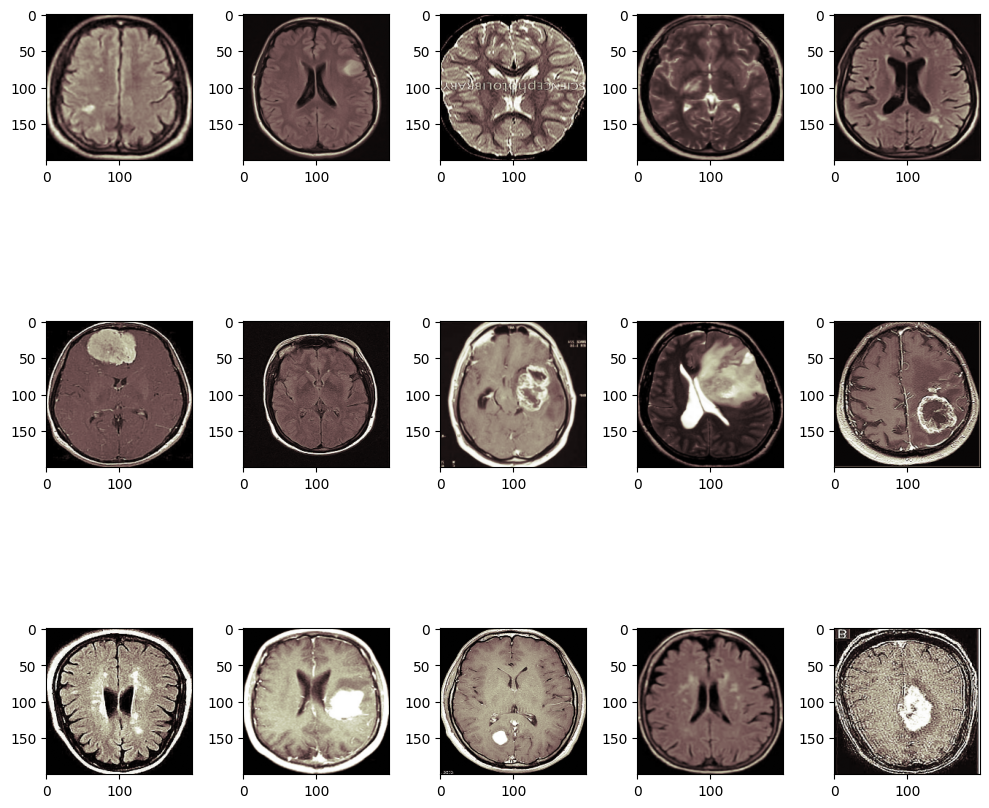

In [2]:
labels = ['yes', 'no']
data_path = '/root/autodl-tmp/dataset/Br35H/cropped'
image_size = 200
x_train, x_test, y_train, y_test = load_data(data_path, labels, image_size)

## Proposed

In [10]:
def block(inputs, filters):

    m = Conv2D(filters, 1, padding='same')(inputs)
    m = BatchNormalization()(m)
    m = ReLU()(m)

    a = Conv2D(filters, 3, padding='same')(inputs)
    a = BatchNormalization()(a)
    a = ReLU()(a)
    
    b = Concatenate()([m, a])

    d = Conv2D(filters * 2, 3, padding='same')(b)
    d = BatchNormalization()(d)
    d = ReLU()(d)

    d = Conv2D(filters * 2, 3, padding='same')(d)
    d = BatchNormalization()(d)
    d = ReLU()(d)
    
    x = Concatenate()([b, d])

    m = Conv2D(filters*4, 1, padding='same')(inputs)
    m = BatchNormalization()(m)
    m = ReLU()(m)
    
    x = Add()([m, x])

    y = Conv2D(filters*2, 1)(x)
    y = BatchNormalization()(y)
    y = ReLU()(y)
    
    return y


def channel_attention(inputs, reduction=8):
    shape = K.int_shape(inputs)
    x = MaxPooling2D(pool_size=(shape[1], shape[2]))(inputs)
    x = Conv2D(shape[3] // reduction, 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = Activation('relu')(x)
    x = Conv2D(shape[3], 1, padding='same', kernel_initializer='he_normal', use_bias=False)(x)
    x = Activation('sigmoid')(x)
    x = Multiply()([x, inputs])
    
    return x

def new_attention(inputs):

    b, h, w, c = inputs.shape.as_list()

    x = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(inputs)
    y = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(inputs)

    x = tf.reshape(x, [-1, 1, h*w])
    y = tf.reshape(y, [-1, 1, h*w])

    x = K.batch_dot(x, tf.reshape(inputs, [-1, h*w, c]))
    y = K.batch_dot(y, tf.reshape(inputs, [-1, h*w, c]))

    x = tf.reshape(x, [-1, 1, 1, c])
    y = tf.reshape(y, [-1, 1, 1, c])

    z = Multiply()([x, y])
    x = Activation('sigmoid')(z)

    y = channel_attention(inputs)
    x = Add()([x, y])
    
    x = Multiply()([x, inputs])

    return x


def load_model():
    
    K.clear_session()
    inputs = Input(shape=(image_size, image_size, 3))
    
    x = Conv2D(32, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    y = ReLU()(x)

    x = MaxPooling2D()(y)
    x = Conv2D(64, 3, padding='same')(x)
    x = BatchNormalization()(x)
    z = ReLU()(x)

    x = MaxPooling2D()(z)
    x = Concatenate()([ Conv2D(32, 5, strides=4, padding='same')(y), x])
    k = block(x, 64)

    x = MaxPooling2D()(k)
    x = Concatenate()([ Conv2D(32, 9, strides=8, padding='same')(y), Conv2D(64, 5, strides=4, padding='same')(z),  x])
    j = block(x, 128)
    
    x = MaxPooling2D()(j)
    x = Concatenate()([ Conv2D(64, 9, strides=8, padding='valid')(z), Conv2D(128, 5, strides=4, padding='valid')(k),  x])
    x = block(x, 256)
    
    x = new_attention(x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(2, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=x)
    
    return model

Epoch 1/50
59/60 [============================>.] - ETA: 0s - loss: 0.7044 - accuracy: 0.6874
Epoch 1: saving model to proposed.h5
Epoch 1: 5.39 seconds
60/60 [==============================] - 5s 60ms/step - loss: 0.7028 - accuracy: 0.6889 - val_loss: 0.6925 - val_accuracy: 0.5292 - lr: 1.0000e-04
Epoch 2/50
59/60 [============================>.] - ETA: 0s - loss: 0.4722 - accuracy: 0.7886
Epoch 2: saving model to proposed.h5
Epoch 2: 3.21 seconds
60/60 [==============================] - 3s 54ms/step - loss: 0.4748 - accuracy: 0.7903 - val_loss: 0.8082 - val_accuracy: 0.5292 - lr: 1.0000e-04
Epoch 3/50
59/60 [============================>.] - ETA: 0s - loss: 0.3912 - accuracy: 0.8352
Epoch 3: saving model to proposed.h5
Epoch 3: 3.25 seconds
60/60 [==============================] - 3s 54ms/step - loss: 0.3922 - accuracy: 0.8347 - val_loss: 1.0406 - val_accuracy: 0.5083 - lr: 1.0000e-04
Epoch 4/50
59/60 [============================>.] - ETA: 0s - loss: 0.2878 - accuracy: 0.8771
Epoch 

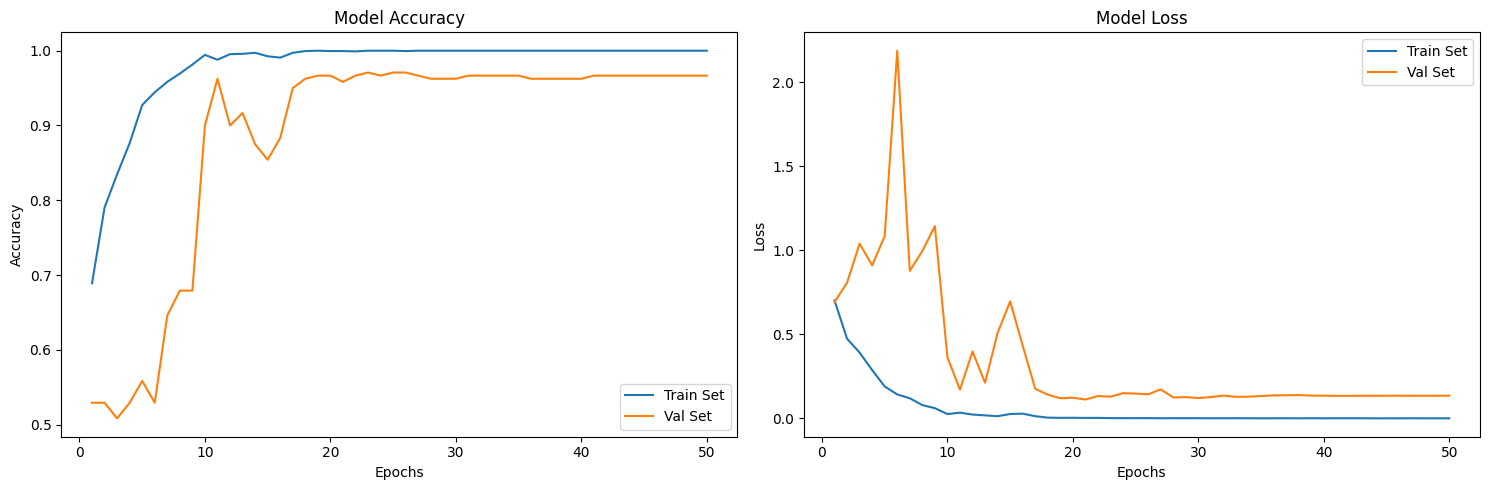

19/19 [==============================] - 0s 14ms/step - loss: 0.0821 - accuracy: 0.9867
Test Accuracy:  98.67
              precision    recall  f1-score   support

         yes     0.9834    0.9900    0.9867       300
          no     0.9899    0.9833    0.9866       300

    accuracy                         0.9867       600
   macro avg     0.9867    0.9867    0.9867       600
weighted avg     0.9867    0.9867    0.9867       600



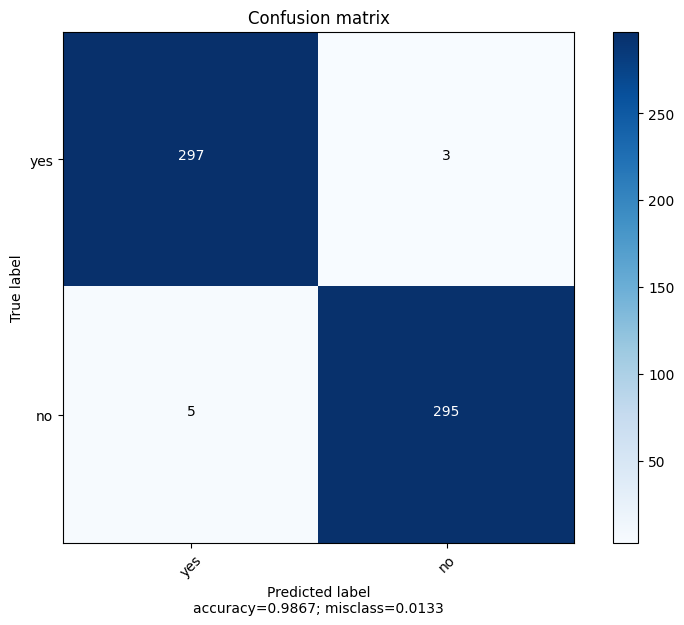

In [13]:
model = load_model()
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='proposed.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## VGG16

Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 0.6916 - accuracy: 0.5278
Epoch 1: saving model to VGG16.h5
Epoch 1: 6.47 seconds
60/60 [==============================] - 6s 83ms/step - loss: 0.6916 - accuracy: 0.5278 - val_loss: 0.6926 - val_accuracy: 0.5833 - lr: 1.0000e-04
Epoch 2/50
60/60 [==============================] - ETA: 0s - loss: 0.6845 - accuracy: 0.5523
Epoch 2: saving model to VGG16.h5
Epoch 2: 4.49 seconds
60/60 [==============================] - 4s 75ms/step - loss: 0.6845 - accuracy: 0.5523 - val_loss: 0.7703 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 3/50
60/60 [==============================] - ETA: 0s - loss: 0.6760 - accuracy: 0.5852
Epoch 3: saving model to VGG16.h5
Epoch 3: 4.53 seconds
60/60 [==============================] - 5s 76ms/step - loss: 0.6760 - accuracy: 0.5852 - val_loss: 0.6870 - val_accuracy: 0.5333 - lr: 1.0000e-04
Epoch 4/50
60/60 [==============================] - ETA: 0s - loss: 0.6817 - accuracy: 0.5528
Epoch 4: saving

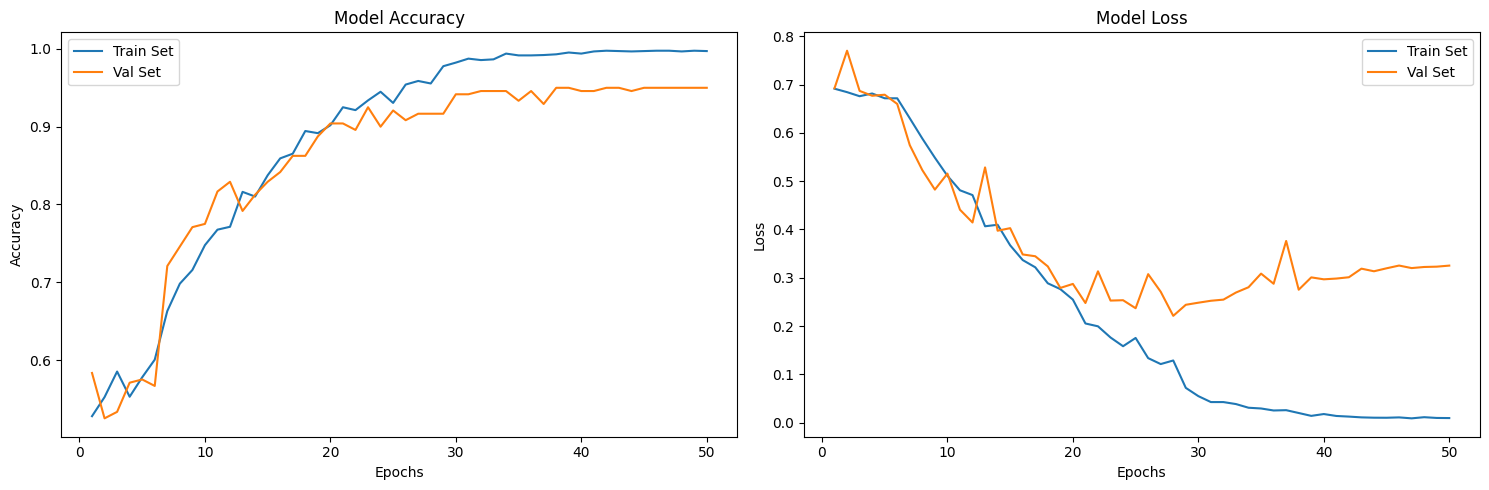

19/19 [==============================] - 0s 22ms/step - loss: 0.1536 - accuracy: 0.9600
Test Accuracy:  96.0
              precision    recall  f1-score   support

         yes     0.9631    0.9567    0.9599       300
          no     0.9570    0.9633    0.9601       300

    accuracy                         0.9600       600
   macro avg     0.9600    0.9600    0.9600       600
weighted avg     0.9600    0.9600    0.9600       600



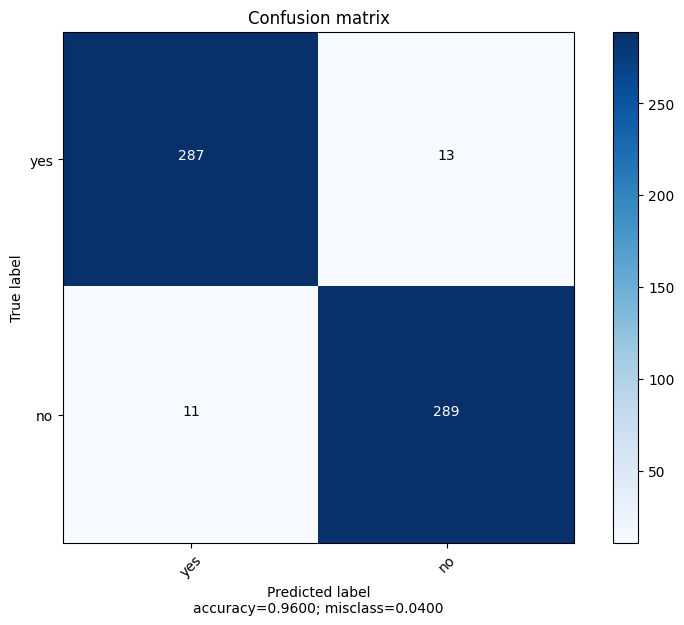

In [14]:
net = VGG16(weights=None, include_top=False, input_shape=(image_size, image_size, 3))

model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(2, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='VGG16.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)


## DenseNet121

Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 0.5665 - accuracy: 0.7097
Epoch 1: saving model to DenseNet121.h5
Epoch 1: 12.77 seconds
60/60 [==============================] - 13s 99ms/step - loss: 0.5665 - accuracy: 0.7097 - val_loss: 0.8719 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 2/50
60/60 [==============================] - ETA: 0s - loss: 0.4262 - accuracy: 0.8069
Epoch 2: saving model to DenseNet121.h5
Epoch 2: 4.39 seconds
60/60 [==============================] - 4s 73ms/step - loss: 0.4262 - accuracy: 0.8069 - val_loss: 1.2918 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 3/50
60/60 [==============================] - ETA: 0s - loss: 0.3150 - accuracy: 0.8736
Epoch 3: saving model to DenseNet121.h5
Epoch 3: 4.48 seconds
60/60 [==============================] - 4s 75ms/step - loss: 0.3150 - accuracy: 0.8736 - val_loss: 2.4148 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 4/50
60/60 [==============================] - ETA: 0s - loss: 0.2305 - accuracy: 0.

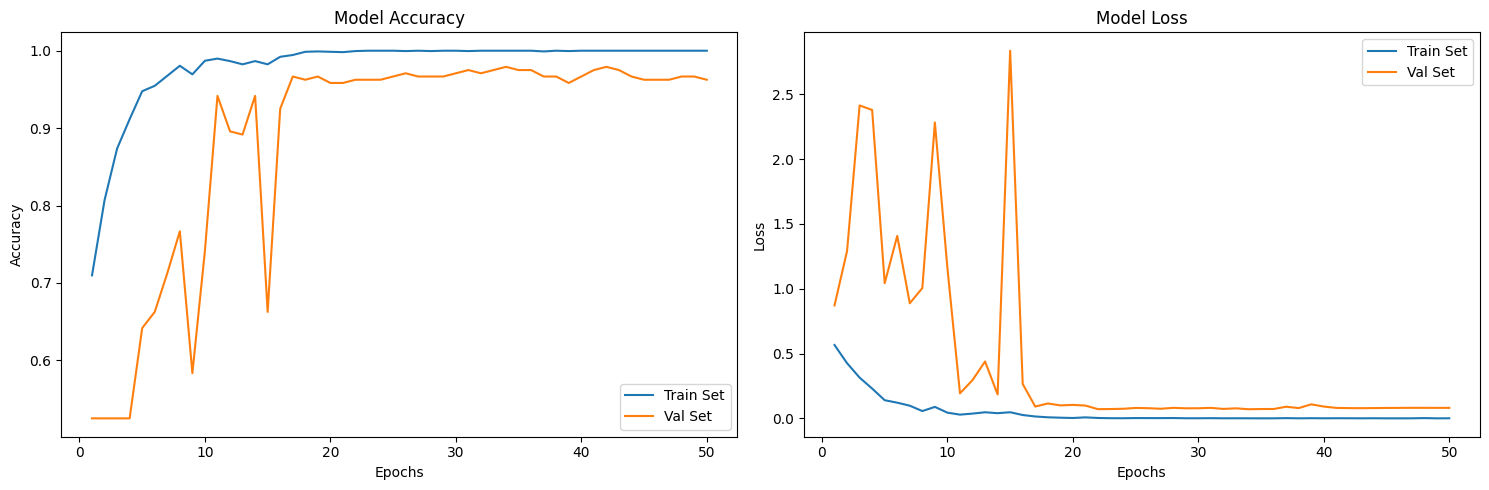

19/19 [==============================] - 0s 16ms/step - loss: 0.0588 - accuracy: 0.9833
Test Accuracy:  98.33
              precision    recall  f1-score   support

         yes     0.9866    0.9800    0.9833       300
          no     0.9801    0.9867    0.9834       300

    accuracy                         0.9833       600
   macro avg     0.9834    0.9833    0.9833       600
weighted avg     0.9834    0.9833    0.9833       600



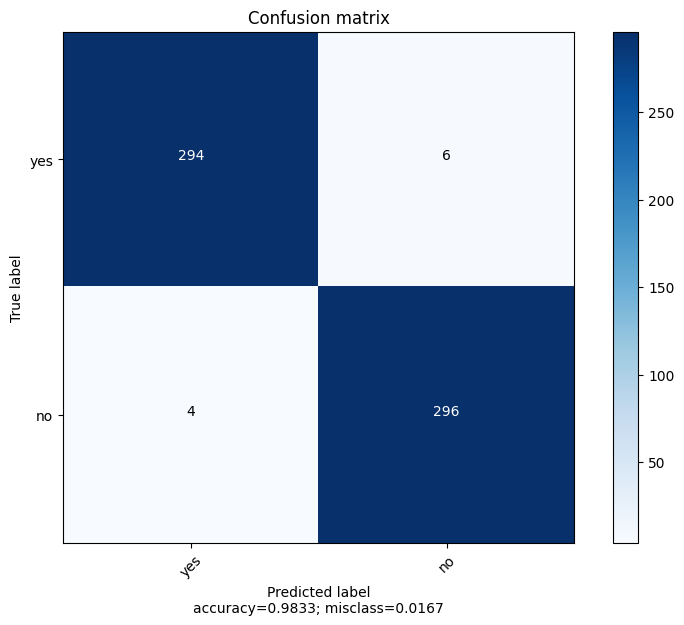

In [15]:
net = DenseNet121(weights=None, include_top=False, input_shape=(image_size, image_size, 3))

model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(2, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='DenseNet121.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## Xception

Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 0.5389 - accuracy: 0.7167
Epoch 1: saving model to Xception.h5
Epoch 1: 11.56 seconds
60/60 [==============================] - 12s 140ms/step - loss: 0.5389 - accuracy: 0.7167 - val_loss: 0.6925 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 2/50
60/60 [==============================] - ETA: 0s - loss: 0.2234 - accuracy: 0.9167
Epoch 2: saving model to Xception.h5
Epoch 2: 7.75 seconds
60/60 [==============================] - 8s 129ms/step - loss: 0.2234 - accuracy: 0.9167 - val_loss: 0.6919 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 3/50
60/60 [==============================] - ETA: 0s - loss: 0.0653 - accuracy: 0.9755
Epoch 3: saving model to Xception.h5
Epoch 3: 7.68 seconds
60/60 [==============================] - 8s 128ms/step - loss: 0.0653 - accuracy: 0.9755 - val_loss: 0.6938 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 4/50
60/60 [==============================] - ETA: 0s - loss: 0.0368 - accuracy: 0.9870
E

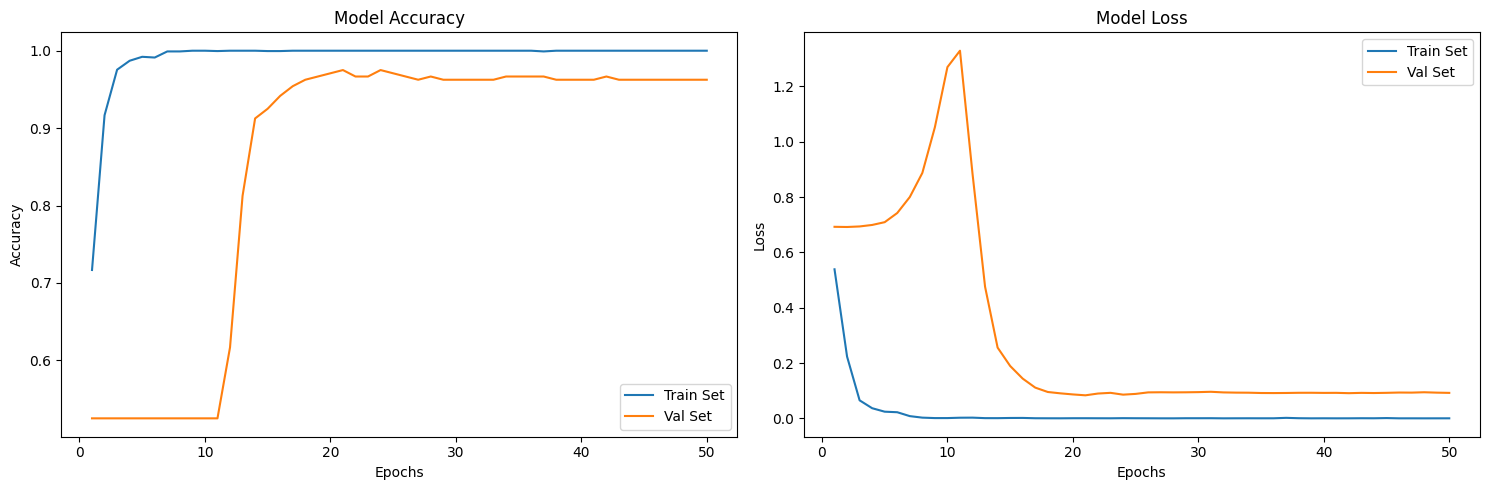

19/19 [==============================] - 0s 17ms/step - loss: 0.1234 - accuracy: 0.9733
Test Accuracy:  97.33
              precision    recall  f1-score   support

         yes     0.9733    0.9733    0.9733       300
          no     0.9733    0.9733    0.9733       300

    accuracy                         0.9733       600
   macro avg     0.9733    0.9733    0.9733       600
weighted avg     0.9733    0.9733    0.9733       600



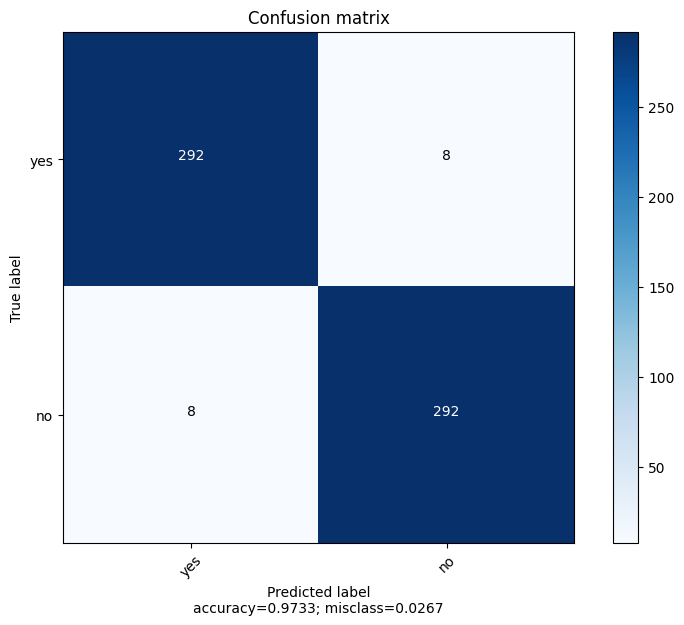

In [16]:
net = Xception(weights=None, include_top=False, input_shape=(image_size, image_size, 3))

model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(2, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='Xception.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## ResNet50

Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 1.0477 - accuracy: 0.5690
Epoch 1: saving model to ResNet50.h5
Epoch 1: 8.22 seconds
60/60 [==============================] - 8s 73ms/step - loss: 1.0477 - accuracy: 0.5690 - val_loss: 0.7171 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 2/50
60/60 [==============================] - ETA: 0s - loss: 0.9705 - accuracy: 0.6213
Epoch 2: saving model to ResNet50.h5
Epoch 2: 3.67 seconds
60/60 [==============================] - 4s 61ms/step - loss: 0.9705 - accuracy: 0.6213 - val_loss: 1.1536 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 3/50
60/60 [==============================] - ETA: 0s - loss: 0.7385 - accuracy: 0.7000
Epoch 3: saving model to ResNet50.h5
Epoch 3: 3.65 seconds
60/60 [==============================] - 4s 61ms/step - loss: 0.7385 - accuracy: 0.7000 - val_loss: 1.6201 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 4/50
60/60 [==============================] - ETA: 0s - loss: 0.4831 - accuracy: 0.7866
Epoch 

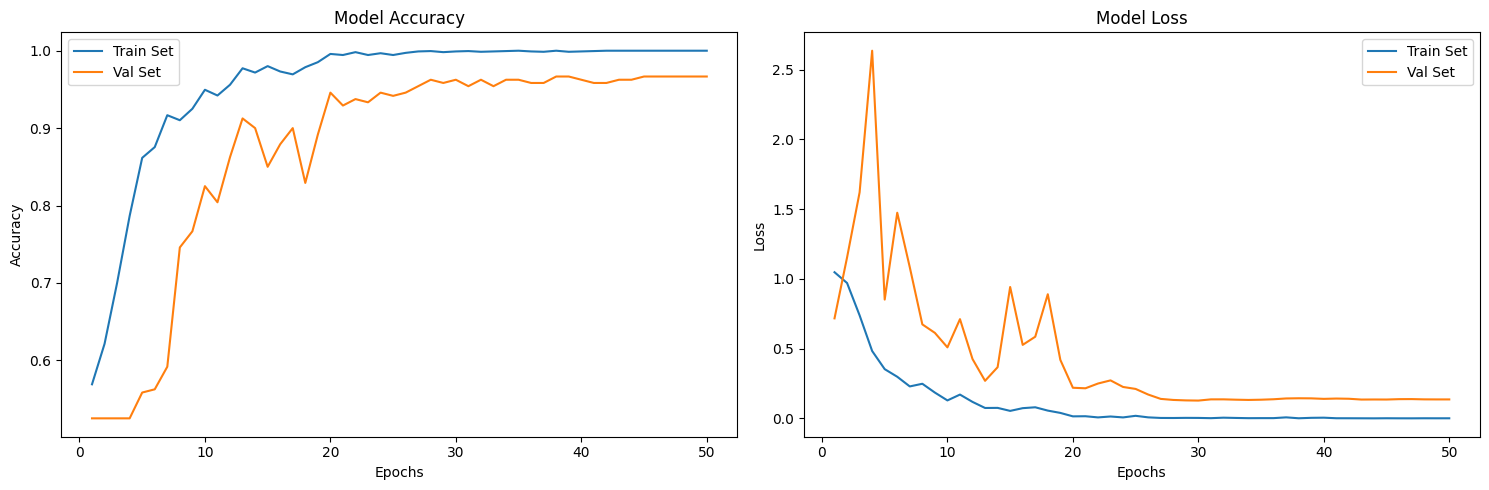

19/19 [==============================] - 0s 15ms/step - loss: 0.2596 - accuracy: 0.9583
Test Accuracy:  95.83
              precision    recall  f1-score   support

         yes     0.9599    0.9567    0.9583       300
          no     0.9568    0.9600    0.9584       300

    accuracy                         0.9583       600
   macro avg     0.9583    0.9583    0.9583       600
weighted avg     0.9583    0.9583    0.9583       600



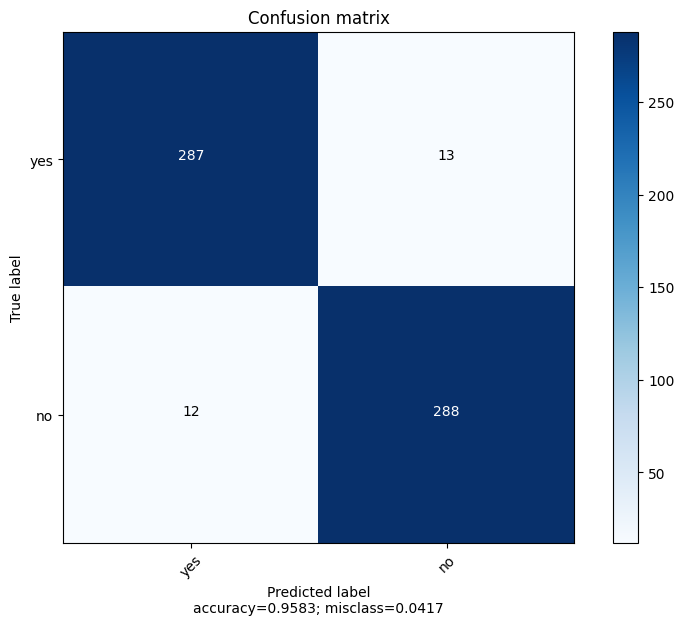

In [17]:
net = ResNet50(weights=None, include_top=False, input_shape=(image_size, image_size, 3))

model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(2, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='ResNet50.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## EfficientNetB0

Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 0.7131 - accuracy: 0.5917
Epoch 1: saving model to EfficientNetB0.h5
Epoch 1: 11.58 seconds
60/60 [==============================] - 12s 110ms/step - loss: 0.7131 - accuracy: 0.5917 - val_loss: 0.6921 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 2/50
60/60 [==============================] - ETA: 0s - loss: 0.6558 - accuracy: 0.6255
Epoch 2: saving model to EfficientNetB0.h5
Epoch 2: 5.48 seconds
60/60 [==============================] - 5s 91ms/step - loss: 0.6558 - accuracy: 0.6255 - val_loss: 0.6985 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 3/50
60/60 [==============================] - ETA: 0s - loss: 0.6446 - accuracy: 0.6352
Epoch 3: saving model to EfficientNetB0.h5
Epoch 3: 5.44 seconds
60/60 [==============================] - 5s 91ms/step - loss: 0.6446 - accuracy: 0.6352 - val_loss: 0.7073 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 4/50
60/60 [==============================] - ETA: 0s - loss: 0.6077 - ac

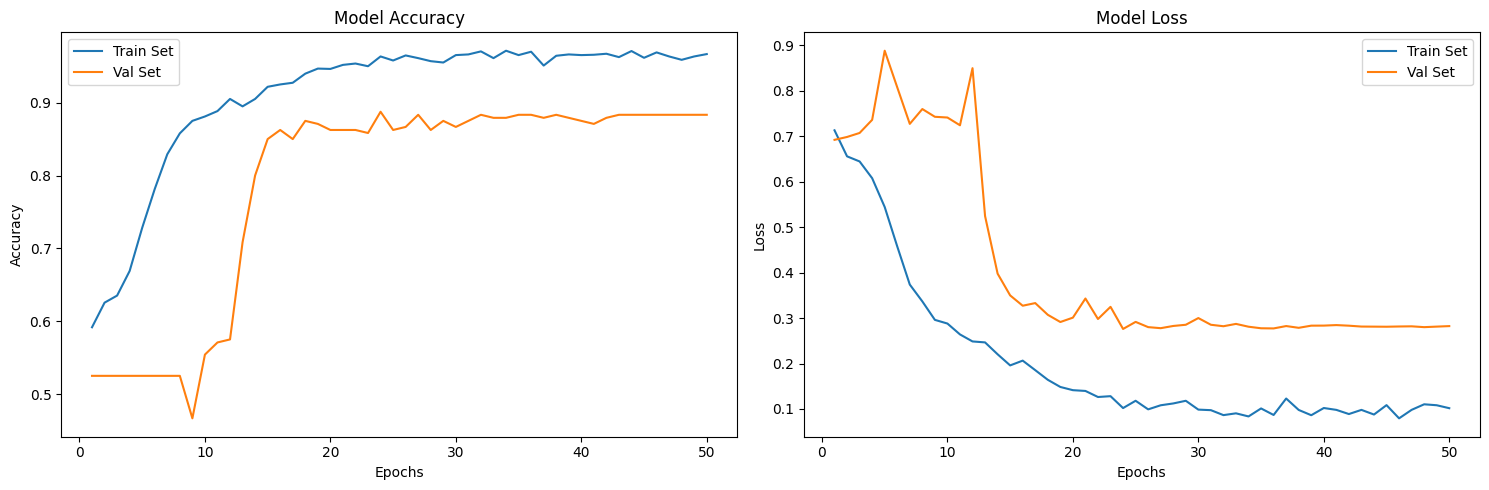

19/19 [==============================] - 0s 13ms/step - loss: 0.3043 - accuracy: 0.9017
Test Accuracy:  90.17
              precision    recall  f1-score   support

         yes     0.9057    0.8967    0.9012       300
          no     0.8977    0.9067    0.9022       300

    accuracy                         0.9017       600
   macro avg     0.9017    0.9017    0.9017       600
weighted avg     0.9017    0.9017    0.9017       600



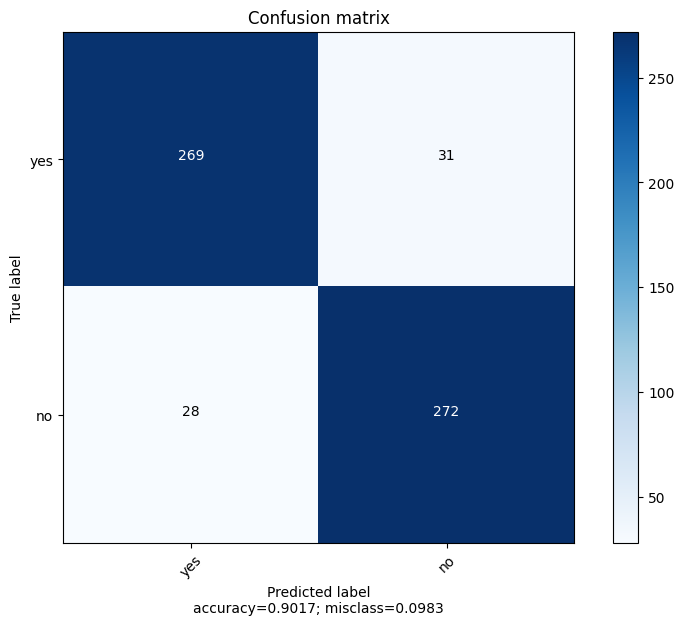

In [18]:
net = EfficientNetB0(weights=None, include_top=False, input_shape=(image_size, image_size, 3))

model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(2, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='EfficientNetB0.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## InceptionV3

Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 0.6653 - accuracy: 0.6690
Epoch 1: saving model to InceptionV3.h5
Epoch 1: 8.71 seconds
60/60 [==============================] - 9s 71ms/step - loss: 0.6653 - accuracy: 0.6690 - val_loss: 0.7332 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 2/50
59/60 [============================>.] - ETA: 0s - loss: 0.5056 - accuracy: 0.7895
Epoch 2: saving model to InceptionV3.h5
Epoch 2: 3.26 seconds
60/60 [==============================] - 3s 54ms/step - loss: 0.5056 - accuracy: 0.7880 - val_loss: 1.1839 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 3/50
60/60 [==============================] - ETA: 0s - loss: 0.3702 - accuracy: 0.8421
Epoch 3: saving model to InceptionV3.h5
Epoch 3: 3.31 seconds
60/60 [==============================] - 3s 55ms/step - loss: 0.3702 - accuracy: 0.8421 - val_loss: 1.1406 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 4/50
60/60 [==============================] - ETA: 0s - loss: 0.2818 - accuracy: 0.88

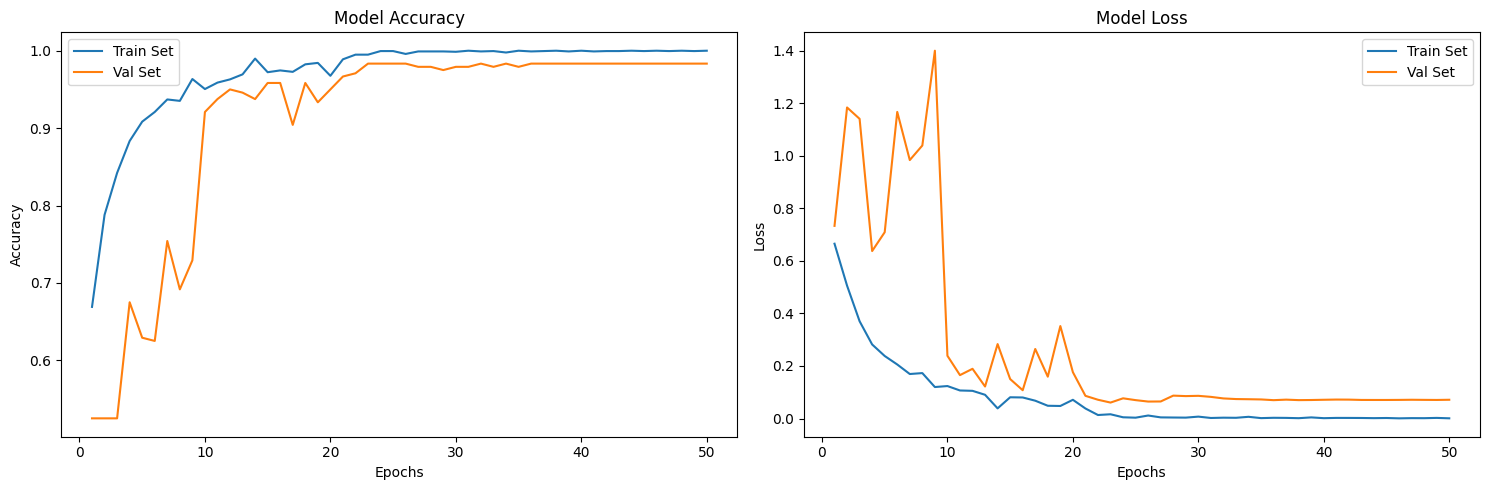

19/19 [==============================] - 0s 14ms/step - loss: 0.0754 - accuracy: 0.9800
Test Accuracy:  98.0
              precision    recall  f1-score   support

         yes     0.9832    0.9767    0.9799       300
          no     0.9768    0.9833    0.9801       300

    accuracy                         0.9800       600
   macro avg     0.9800    0.9800    0.9800       600
weighted avg     0.9800    0.9800    0.9800       600



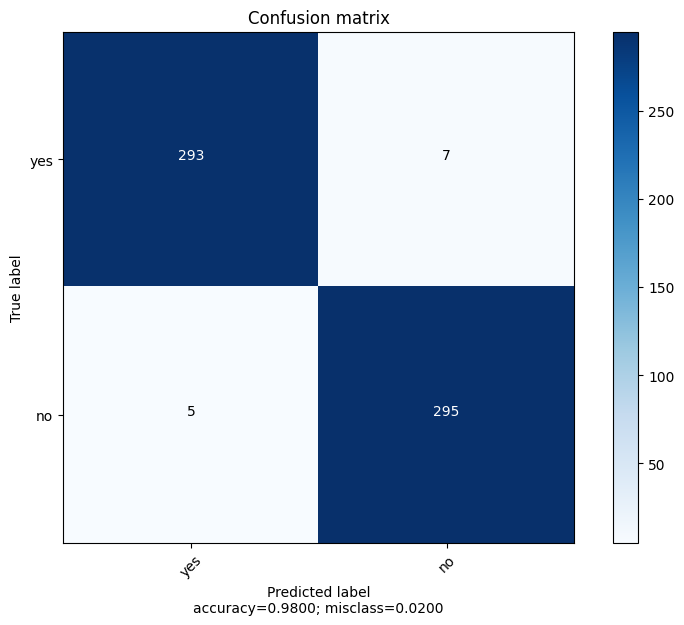

In [19]:
net = InceptionV3(weights=None, include_top=False, input_shape=(image_size, image_size, 3))

model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(2, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='InceptionV3.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## SqueezeNet

In [20]:
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout
import warnings
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.utils import get_source_inputs
from keras.utils import get_file
from keras.utils import layer_utils


sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_NO_TOP = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5"


def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


def SqueezeNet(include_top=True, weights='imagenet',
               input_tensor=None, input_shape=None,
               pooling=None,
               classes=2):
    
        
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')


    input_shape = _obtain_input_shape(input_shape,
                                      default_size=227,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor


    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    if include_top:
        
        x = Dropout(0.5, name='drop9')(x)

        x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
        x = Activation('relu', name='relu_conv10')(x)
        x = GlobalAveragePooling2D()(x)
        x = Activation('softmax', name='loss')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling=='max':
            x = GlobalMaxPooling2D()(x)
        elif pooling==None:
            pass
        else:
            raise ValueError("Unknown argument for 'pooling'=" + pooling)

   
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, x, name='squeezenet')


    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
            
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

Epoch 1/50
58/60 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5010
Epoch 1: saving model to SqueezeNet.h5
Epoch 1: 2.07 seconds
60/60 [==============================] - 2s 18ms/step - loss: 0.6931 - accuracy: 0.5005 - val_loss: 0.6930 - val_accuracy: 0.4750 - lr: 1.0000e-04
Epoch 2/50
56/60 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.4950
Epoch 2: saving model to SqueezeNet.h5
Epoch 2: 0.92 seconds
60/60 [==============================] - 1s 15ms/step - loss: 0.6934 - accuracy: 0.4907 - val_loss: 0.6930 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 3/50
55/60 [==========================>...] - ETA: 0s - loss: 0.6932 - accuracy: 0.4859
Epoch 3: saving model to SqueezeNet.h5
Epoch 3: 0.81 seconds
60/60 [==============================] - 1s 14ms/step - loss: 0.6932 - accuracy: 0.4917 - val_loss: 0.6931 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 4/50
56/60 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5094


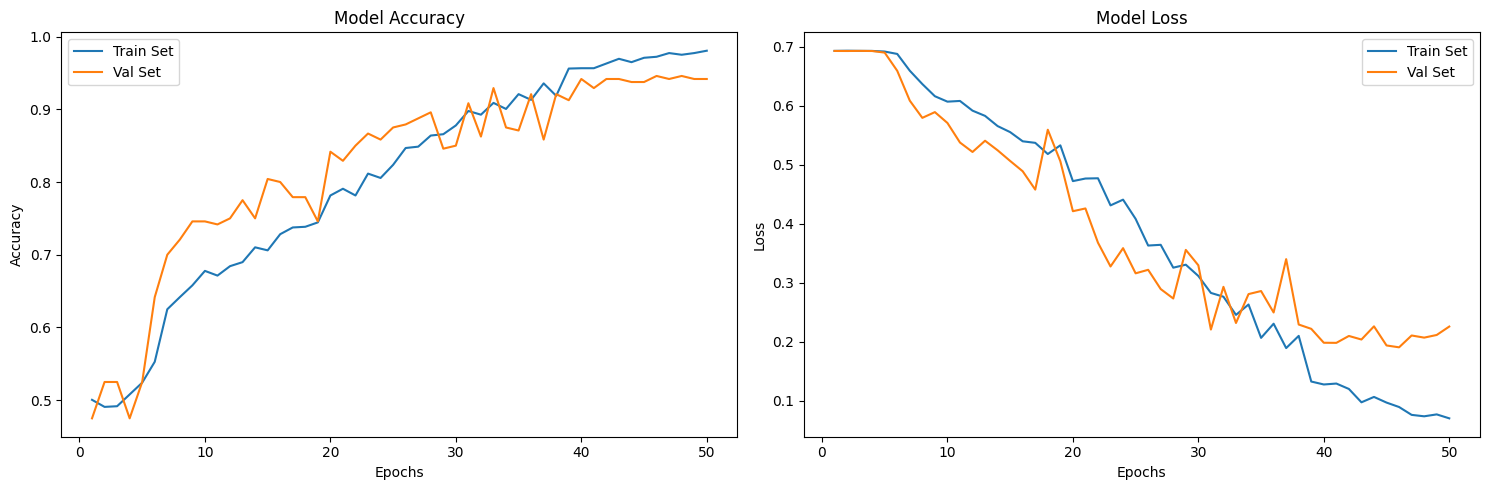

19/19 [==============================] - 0s 5ms/step - loss: 0.1457 - accuracy: 0.9583
Test Accuracy:  95.83
              precision    recall  f1-score   support

         yes     0.9791    0.9367    0.9574       300
          no     0.9393    0.9800    0.9592       300

    accuracy                         0.9583       600
   macro avg     0.9592    0.9583    0.9583       600
weighted avg     0.9592    0.9583    0.9583       600



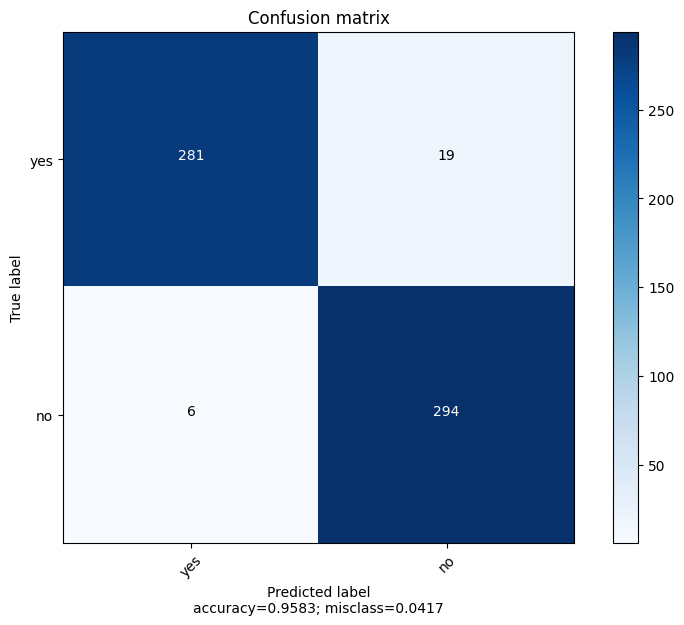

In [21]:
net = SqueezeNet(weights=None, include_top=False, input_shape=(image_size, image_size, 3))

model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(2, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='SqueezeNet.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## MobileNetV2

Epoch 1/50
60/60 [==============================] - ETA: 0s - loss: 1.1502 - accuracy: 0.5560
Epoch 1: saving model to MobileNetV2.h5
Epoch 1: 8.09 seconds
60/60 [==============================] - 8s 73ms/step - loss: 1.1502 - accuracy: 0.5560 - val_loss: 0.7497 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 2/50
60/60 [==============================] - ETA: 0s - loss: 0.9566 - accuracy: 0.6208
Epoch 2: saving model to MobileNetV2.h5
Epoch 2: 3.71 seconds
60/60 [==============================] - 4s 62ms/step - loss: 0.9566 - accuracy: 0.6208 - val_loss: 1.0735 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 3/50
60/60 [==============================] - ETA: 0s - loss: 0.7001 - accuracy: 0.6926
Epoch 3: saving model to MobileNetV2.h5
Epoch 3: 3.71 seconds
60/60 [==============================] - 4s 62ms/step - loss: 0.7001 - accuracy: 0.6926 - val_loss: 2.2716 - val_accuracy: 0.5250 - lr: 1.0000e-04
Epoch 4/50
60/60 [==============================] - ETA: 0s - loss: 0.5455 - accuracy: 0.75

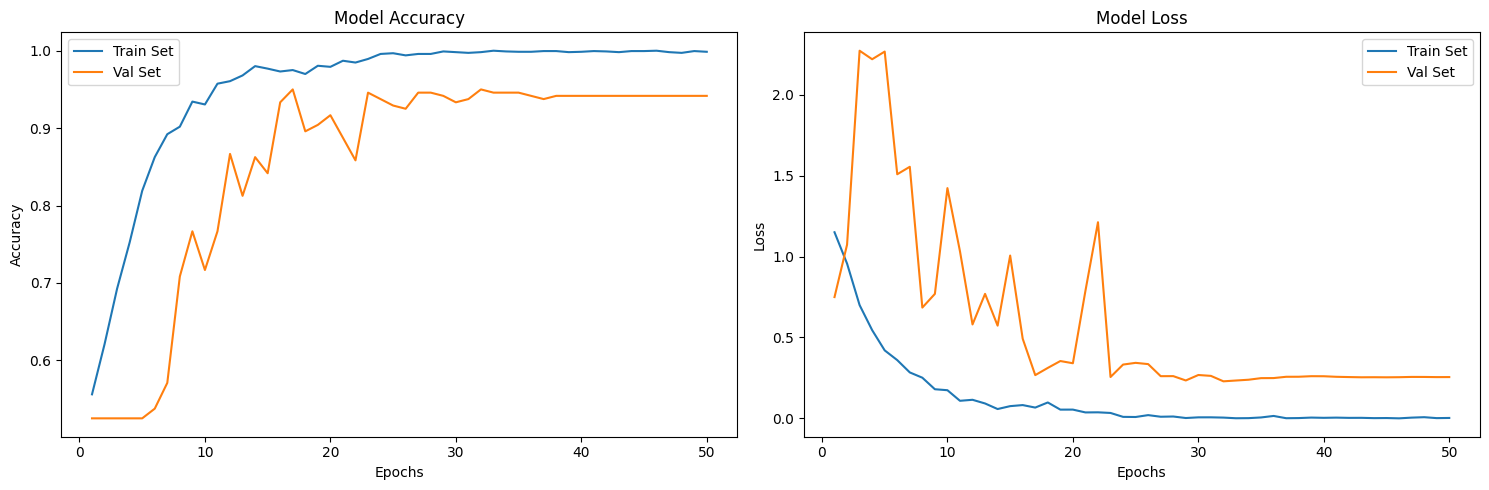

19/19 [==============================] - 0s 15ms/step - loss: 0.2335 - accuracy: 0.9583
Test Accuracy:  95.83
              precision    recall  f1-score   support

         yes     0.9630    0.9533    0.9581       300
          no     0.9538    0.9633    0.9585       300

    accuracy                         0.9583       600
   macro avg     0.9584    0.9583    0.9583       600
weighted avg     0.9584    0.9583    0.9583       600



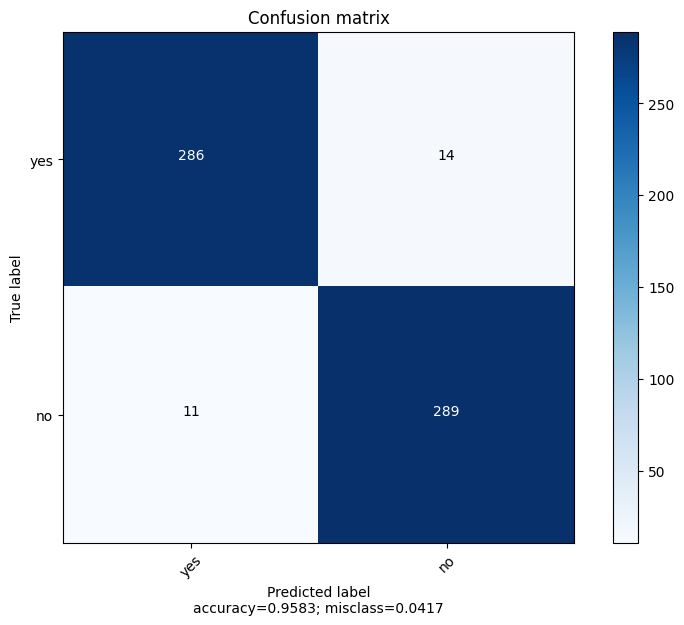

In [47]:
net = MobileNetV2(weights=None,include_top=False, input_shape=(image_size, image_size, 3))

model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(2, activation="softmax")(model)
model = Model(inputs=net.input, outputs=model)

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])


tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint(filepath='MobileNetV2.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='max')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = model.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = model.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)

## AlexNet

In [23]:
from keras_applications.imagenet_utils import _obtain_input_shape
from keras import backend as K
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, Conv2D, BatchNormalization, MaxPool2D, Flatten
import warnings
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.utils import get_source_inputs
from keras.utils import get_file
from keras.utils import layer_utils

alexnet_cnn = Sequential()
alexnet_cnn.add(Conv2D(96, kernel_size = 11, strides = 4, activation = 'relu', input_shape = (image_size, image_size, 3), name = 'Conv2D-1'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-1'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-1'))
alexnet_cnn.add(Conv2D(256, kernel_size = 5, padding = 'same', activation = 'relu', name = 'Conv2D-2'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-2'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-2'))
alexnet_cnn.add(Conv2D(384, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-3'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-3'))
alexnet_cnn.add(Conv2D(384, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-4'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-4'))
alexnet_cnn.add(Conv2D(256, kernel_size = 3, padding = 'same', activation = 'relu', name = 'Conv2D-5'))
alexnet_cnn.add(BatchNormalization(name = 'Batch-Normalization-5'))
alexnet_cnn.add(MaxPool2D(pool_size = 3, strides = 2, name = 'Max-Pooling-3'))
alexnet_cnn.add(Flatten(name = 'Flatten-Layer-1'))
alexnet_cnn.add(Dense(128, activation = 'relu', name = 'Hidden-Layer-1'))
alexnet_cnn.add(Dropout(rate = 0.5, name = 'Dropout-Layer-1'))
alexnet_cnn.add(Dense(64, activation = 'relu', name = 'Hidden-Layer-2'))
alexnet_cnn.add(Dropout(rate = 0.5, name = 'Dropout-Layer-2'))
alexnet_cnn.add(Dense(2, activation = 'softmax', name = 'Output-Layer'))

Epoch 1/50
58/60 [============================>.] - ETA: 0s - loss: 1.0915 - accuracy: 0.5699
Epoch 1: saving model to AlexNet.h5
Epoch 1: 1.53 seconds
60/60 [==============================] - 2s 15ms/step - loss: 1.0839 - accuracy: 0.5685 - val_loss: 0.6990 - val_accuracy: 0.4750 - lr: 1.0000e-04
Epoch 2/50
60/60 [==============================] - ETA: 0s - loss: 0.7109 - accuracy: 0.6171
Epoch 2: saving model to AlexNet.h5
Epoch 2: 0.62 seconds
60/60 [==============================] - 1s 10ms/step - loss: 0.7109 - accuracy: 0.6171 - val_loss: 0.6970 - val_accuracy: 0.4625 - lr: 1.0000e-04
Epoch 3/50
55/60 [==========================>...] - ETA: 0s - loss: 0.5799 - accuracy: 0.6798
Epoch 3: saving model to AlexNet.h5
Epoch 3: 0.58 seconds
60/60 [==============================] - 1s 10ms/step - loss: 0.5771 - accuracy: 0.6847 - val_loss: 0.7128 - val_accuracy: 0.5500 - lr: 1.0000e-04
Epoch 4/50
59/60 [============================>.] - ETA: 0s - loss: 0.5490 - accuracy: 0.6963
Epoch 4: 

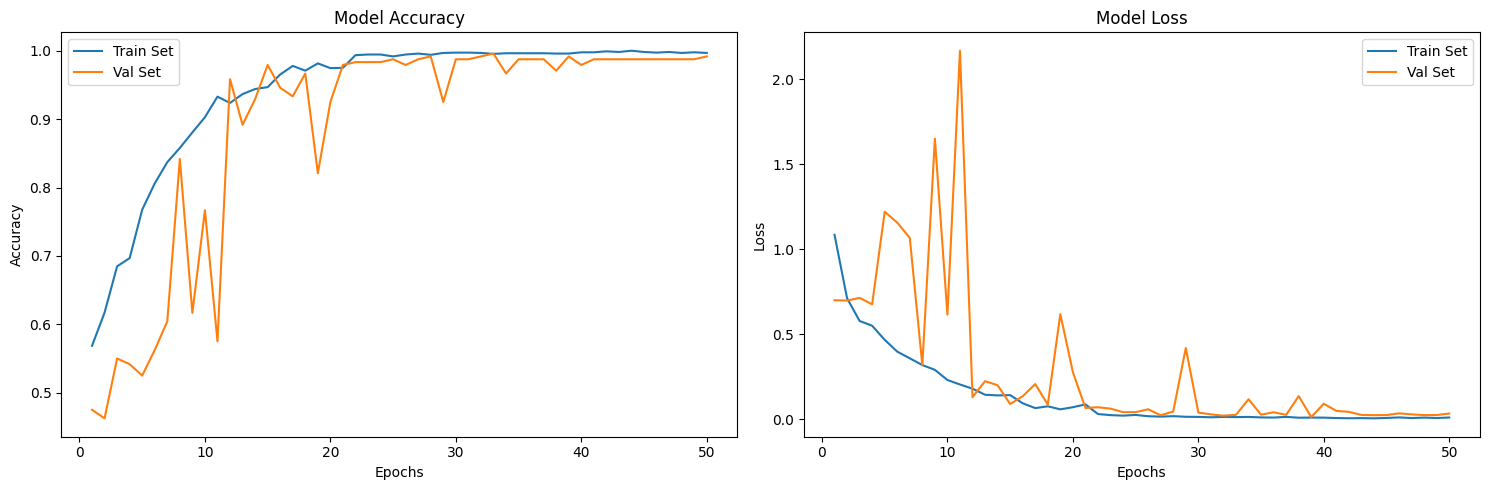

19/19 [==============================] - 0s 4ms/step - loss: 0.0698 - accuracy: 0.9850
Test Accuracy:  98.5
              precision    recall  f1-score   support

         yes     0.9899    0.9800    0.9849       300
          no     0.9802    0.9900    0.9851       300

    accuracy                         0.9850       600
   macro avg     0.9850    0.9850    0.9850       600
weighted avg     0.9850    0.9850    0.9850       600



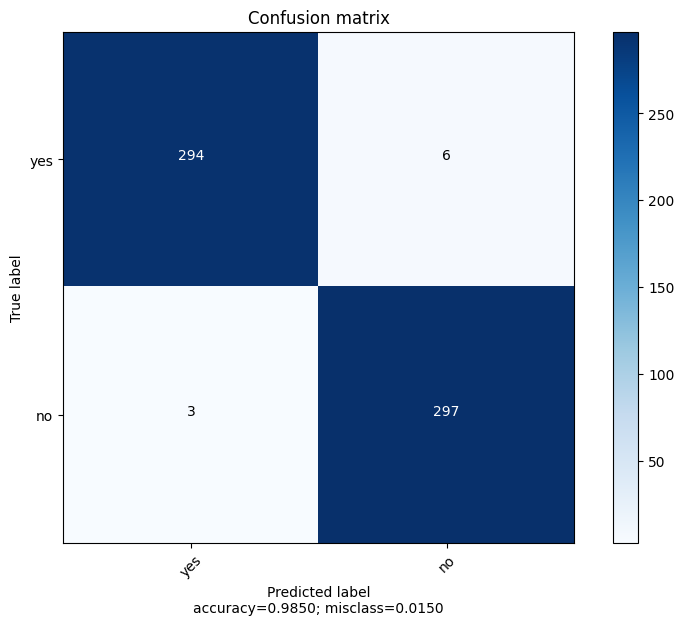

In [24]:
net = alexnet_cnn
adam = keras.optimizers.Adam(learning_rate=0.0001)
net.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs')
Checkpoint = ModelCheckpoint(filepath='AlexNet.h5',
                             monitor='val_accuracy', verbose=1, save_best_only=False, mode='min')
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 5, min_delta = 0.001,
                              mode='auto',verbose=1)
time_callback = TimeHistory()
history = net.fit(x_train,y_train,validation_split=0.1, epochs =50, verbose=1, batch_size=36,
                   callbacks=[tensorboard,Checkpoint,reduce_lr, time_callback])

draw_curve(history)
pred = net.predict(x_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)
loss,acc = net.evaluate(x_test,y_test,verbose = 1)
draw_matrix(labels, y_test_new, pred, acc)